In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

## Objectives

First, we wish to determine when a project is to be deemed "unsuitable" for email marketing based on its performance. We define "unsuitable" as a less than chance probability of a project getting fully funded given its rate of funding. 

Next, we examine progress indicators of potentially successful projects. We do this 

In [2]:
donations_dat = pd.read_csv('data/data_clean/donations_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv').sample(50000)

In [3]:
merged_proj_dona = projects_notext_dat.merge(donations_dat, on='project_id')

In [4]:
def days(date, posted):
    return (date - posted) / (60*60*24) # days

merged_proj_dona['delta'] = days(merged_proj_dona['date'].values, merged_proj_dona['posted'])
merged_proj_dona = merged_proj_dona[merged_proj_dona['status'] < 2]

In [5]:
simplified_projs = merged_proj_dona[['project_id', 'cost', 'status', 'amount', 'delta']]
simplified_projs[:10]

,project_id,cost,status,amount,delta
0,991720672d598a885e5131a4cdab9fd9,335.26,1,99.00,3.944803
1,991720672d598a885e5131a4cdab9fd9,335.26,1,5.00,18.445683
2,991720672d598a885e5131a4cdab9fd9,335.26,1,25.00,4.525463
3,991720672d598a885e5131a4cdab9fd9,335.26,1,50.00,17.947905
4,991720672d598a885e5131a4cdab9fd9,335.26,1,32.26,18.630984
5,144dab84f1e5c8213738e4f40e64e1d1,173.81,1,74.40,121.710150
6,144dab84f1e5c8213738e4f40e64e1d1,173.81,1,25.00,49.944630
7,393e89b2fa927af6dbe846fe5e6bf678,673.98,1,25.00,8.977975
8,5ec88f8e2dccabb557023cc168d0f7e0,262.56,1,131.28,7.609525
9,19574c2230e83042b1a7cccb1f3a6b43,474.73,1,474.73,17.942002


In [ ]:
# projs_grouped = simplified_projs.sort_values(['project_id', 'delta']).groupby('project_id')

In [ ]:
# funding_time = []
# for name, group in funded_projs:
#     r = group['amount'].values / group['cost'].max()
#     funding_time.append([r, group['delta'].values])
#     if len(funding_time) % 1000 == 0:
#         break
        
# funding_time = np.array(funding_time)

# expiring_time = []
# for name, group in expired_projs:
#     r = group['amount'].values / group['cost'].max()
#     expiring_time.append([r, group['delta'].values])
#     if len(expiring_time) % 1000 == 0:
#         break
        
# expiring_time = np.array(expiring_time)

In [ ]:
# plt.xlabel('Days since Project Inception')
# plt.ylabel('Portion of Porject Funded')
# plt.ylim([0, 1])
# for st in funding_time:
#     if st[1].min() > 0 and st[1].max() < 120:
#         plt.scatter(st[1], st[0], c='g', alpha=0.05)
# for st in expiring_time:
#     if st[1].min() > 0 and st[1].max() < 120:
#         plt.scatter(st[1], st[0], c='r', alpha=0.05)

# Probability

In [8]:
projs_mat = simplified_projs.as_matrix()

def support(matrix):
    last_id = ''
    curr_cost = 0
    curr_cumsum = []

    T = len(projs_mat)

    p = np.array(projs_mat[:T])
    p = p[p[:, 4].argsort()]
    p = p[p[:, 0].argsort()[::-1]]

    end_df = []
    
    portions = []
    
    def search(a, ix):
        return a[a[:, 0] == ix]

    for i, row in enumerate(p):
        if last_id is not row[0]:
            cur = search(p, row[0])
            if not cur[(cur[:, 4] < 0) | (cur[:, 4] > 120)].any():
                curr_cost = cur[0][1]
                curr_cumsum = cur[:, 3].cumsum()

                end_df.extend(cur)
                portions.extend(curr_cumsum / curr_cost)

                last_id = row[0]
        if i % 10000 == 0:
            print(i/T)

    a = np.array(end_df)
    return pd.DataFrame({'project_id': a[:, 0], 'cost': a[:, 1], 
                         'status': a[:, 2], 'amount': a[:, 3], 'delta': a[:, 4], 'portion': portions}).astype({'status': np.int})

# import cProfile
# cProfile.run('support(projs_mat)')
filter_proj_delta = support(projs_mat).dropna()

0.0
0.04702010109321735
0.0940402021864347
0.14106030327965205
0.1880804043728694
0.23510050546608674
0.2821206065593041
0.32914070765252146
0.3761608087457388
0.4231809098389562
0.4702010109321735
0.5172211120253909
0.5642412131186082
0.6112613142118255
0.6582814153050429
0.7053015163982602
0.7523216174914776
0.7993417185846949
0.8463618196779124
0.8933819207711297
0.940402021864347
0.9874221229575644


In [9]:
delta_bins = np.arange(0, 121, 1)
portion_bins = np.arange(0, 1.05, 0.05)

filter_proj_delta['delta_bin'] = pd.cut(filter_proj_delta['delta'], delta_bins, labels=False)
filter_proj_delta['portion_bin'] = pd.cut(filter_proj_delta['portion'], portion_bins, labels=False)

In [14]:
proj_binned = filter_proj_delta.groupby(['delta_bin', 'portion_bin'])

proj_matrix = proj_binned['status'].mean().unstack()

In [24]:
proj_prob_subset = proj_matrix.transpose()[::-1].copy()

quantile = 0.95

proj_prob_subset[(proj_prob_subset >= quantile + 0.02) | (proj_prob_subset <= quantile - 0.02)] = np.nan
prob_50 = proj_prob_subset.stack()

df = prob_50.index.to_frame()
prob_50_x = df['delta_bin'].values
prob_50_y = 20-df['portion_bin'].values

z = np.polyfit(prob_50_x, prob_50_y, 3)
polyfit = np.poly1d(z)

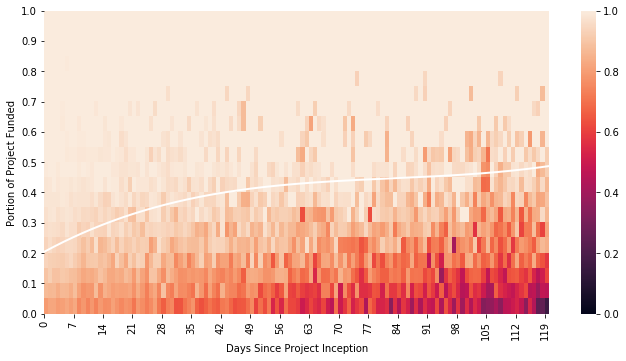

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
fig.tight_layout(rect=[0.05,0.2,1,1])

sns.heatmap(proj_matrix.transpose()[::-1], vmin=0.0, vmax=1.0)
x = np.linspace(0,120,1000)
plt.plot(x, polyfit(x), c='w', linewidth=2)

plt.xticks(np.arange(0, 120, 7) , np.arange(0, 120, 7).tolist())
plt.yticks(np.arange(0, 22, 2) , (np.arange(0, 11, 1) / 10).tolist()[::-1])

plt.xlabel('Days Since Project Inception')
plt.ylabel('Portion of Project Funded');
plt.savefig('probability_of_funded.png')

# Rates

In [ ]:
proj_status = merged_proj_dona.groupby('status')
funded = proj_status.get_group(1)
expired = proj_status.get_group(0)

In [ ]:
funded_projs = funded.sort_values('delta').groupby('project_id')
projs_f_l = len(funded_projs)

expired_projs = expired.sort_values('delta').groupby('project_id')
projs_e_l = len(expired_projs)
projs_f_l, projs_e_l

In [ ]:
projs_f_l

In [ ]:
funded_portions = np.zeros(len(b))
funded_counts = np.zeros(len(b))

c = 0

for name, group in funded_projs:
    d = group['delta'].values
    
    if d[(d < 0) | (d >= 119)].any():
        continue
    
    cost = group['cost'].max()
    amts = group['amount'].cumsum().values
    cut = pd.cut(d, b, labels=False)
    
    funded_portions[cut] += (amts / cost)
    funded_counts[cut] += 1
        
    c += 1
    if c % int(projs_f_l / 2) == 0:
        break
    
funded_x = np.array(funded_portions / funded_counts)

nans, x = np.isnan(funded_x), lambda z: z.nonzero()[0]
funded_x[nans] = np.interp(x(nans), x(~nans), funded_x[~nans])

In [ ]:
expired_portions = np.zeros(len(b))
expired_counts = np.zeros(len(b))

c = 0

for name, group in expired_projs:
    d = group['delta'].values
    
    if d[(d < 0) | (d >= 119)].any():
        continue
    
    cost = group['cost'].max()
    amts = group['amount'].cumsum().values
    cut = pd.cut(d, b, labels=False)
    
    expired_portions[cut] += (amts / cost)
    expired_counts[cut] += 1
        
    c += 1
    if c % int(projs_e_l / 2) == 0:
        break
    
expired_x = np.array(expired_portions / expired_counts)

nans, x = np.isnan(expired_x), lambda z: z.nonzero()[0]
expired_x[nans] = np.interp(x(nans), x(~nans), expired_x[~nans])

In [ ]:
plt.subplots(figsize=(16,5))
plt.axhline(0.5, linestyle=':', alpha=0.9)

# Funded

plt.scatter(b, funded_x, c='k', s=6, alpha=0.8)
funded_smooth = savitzky_golay(funded_x, 31, 3)
plt.plot(b, funded_smooth, linestyle='-.', c='g', alpha=0.8)

cross = np.argwhere(funded_smooth > 0.5).min()
plt.axvline(cross, linestyle=':', alpha=0.9)
plt.axvline(1, linestyle=':', alpha=0.9)
plt.axvline(7, linestyle=':', alpha=0.9)
plt.axvline(30, linestyle=':', alpha=0.9)

# Expired

plt.scatter(b, expired_x, c='k', s=6, alpha=0.8)
expired_smooth = savitzky_golay(expired_x, 31, 3)
plt.plot(b, expired_smooth, linestyle='-.', c='r', alpha=0.8)

# cross = np.argwhere(expired_smooth > 0.5).min()
# plt.axvline(cross, linestyle=':', alpha=0.9)

plt.ylim([-0.1,1.1]);
plt.xlabel('Days since Project Inception')
plt.ylabel('Portion of Project Funded');
# plt.xticks(np.arange(0, 14, 7));

In [ ]:
sns.distplot(funded_x)
sns.distplot(expired_x)

In [ ]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [ ]:
arr = (np.random.rand(15, 5) * 10).astype(int)

In [ ]:
f = []
h = []
for r in arr:
    f.extend(r[3:])
    h.extend(r[0:2])

    
f = np.array(f).reshape(len(f), 1)
h = np.array(h).reshape(len(h), 1)

In [ ]:
print(f.shape, h.shape)
np.concatenate((f, h), axis=1)